In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
import gc
%matplotlib inline
from datetime import datetime
from functools import reduce
import pandas as pd

In [8]:
path_ratings = (r'https://raw.githubusercontent.com/JohnTan38/Recommender/main/dat/')
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table(path_ratings + 'ratings.dat', sep='::', engine='python', names=rnames, header=None) #usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

In [9]:
class KNNRecommender():
    """User-based or Item-based collaborative filtering model that operates on
    dataframes with at least a user-like, item-like, and a rating-like column
    
    Parameters
    ----------
    mode : str, ['item | 'user'], default='item'
        Tells model whether to use item-based or user-based collaborative filtering
    k : int, default=20
        Number of most similar items or users to average for prediction
    basline_algo : object, optional
        Algorithm used to predict baseline scores for each rating. If not provided,
        the mean of all training ratings is used as the baseline. If provided,
        the object must have a fit(X) method and a predict(X) method
    similarity_func : function, default=cosine_similarity
        Function must take a numpy array M of shape (m,n) and return a numpy array
        of shape (m,m) where each element i,j represents the similarity between row
        i and row j of M.
    loop_predict : boolean, default=True
        If True, the model will loop over all user-item pairs in test set and compute
        prediction individually. If False, the model will compute all ratings
        simultaneously. With sparse matrices, looping is typically faster.
        
    Attributes
    ----------
    train_mean : float
        Mean of the training data ratings. Used if baseline_algo is None.
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
        Rating matrix minus baselines
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    knn_indices : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the index of the jth closet [user|item] to i
    knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the similarity between the jth closest [user|item] to i
    """
    def __init__(self, mode='item', k=20, baseline_algo=None,
                 similarity_func=cosine_similarity, loop_predict=True):
        if not mode in ['user', 'item']:
            raise ValueError("'mode' must be either 'user' or 'item', not '{}'!".format(mode))

        self.mode = mode
        self.k = k
        self.baseline_algo = baseline_algo
        self.similarity_func = similarity_func
        self.loop_predict = loop_predict
        
        self.train_mean = None
        self.rating_matrix = None
        self.user_map = None
        self.item_map = None
        self.knn_indices = None
        self.knn_similarities = None
        
    def _get_rating_matrix(self, X):
        """Private function to generate a ratings matrx and mappings for
        the user and item ids to the row and column indices
        
        Parameters
        ----------
        X : pandas.DataFrame, shape=(n_ratings,>=3)
            First 3 columns must be in order of user, item, rating.
        
        Returns
        -------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
        user_map : pandas Series, shape=(n_users,)
            Mapping from the original user id to an integer in the range [0,n_users)
        item_map : pandas Series, shape=(n_items,)
            Mapping from the original item id to an integer in the range [0,n_items)
        """
        user_col, item_col, rating_col = X.columns[:3]
        rating = X[rating_col]
        user_map = pd.Series(
            index=np.unique(X[user_col]),
            data=np.arange(X[user_col].nunique()),
            name='user_map',
        )
        item_map = pd.Series(
            index=np.unique(X[item_col]),
            data=np.arange(X[item_col].nunique()),
            name='columns_map',
        )
        user_inds = X[user_col].map(user_map)
        item_inds = X[item_col].map(item_map)
        rating_matrix = (
            pd.pivot_table(
                data=X,
                values=rating_col,
                index=user_inds,
                columns=item_inds,
            )
            .fillna(0)
            .values
        )
        return rating_matrix, user_map, item_map

    def _get_knn_indices_and_similarities(self, rating_matrix):
        """Private function to find indices and similarities of k nearest
        neighbors for each user or item
        
        Parameters
        ----------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
            Matrix of ratings minus baselines
        
        Returns
        -------
        knn_indices : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the index of the jth closet [user|item] to i
        knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the similarity between the jth closest [user|item] to i
        """
        if self.mode == 'item':
            n_users_or_items = rating_matrix.shape[1]
        else:
            n_users_or_items = rating_matrix.shape[0]
        if self.k > n_users_or_items:
            new_k = n_users_or_items - 1
            print(
                "Warning: k = {} > # {}s = {}! Setting k to {}"
                .format(self.k, n_users_or_items, self.mode, new_k)
            )
            self.k = new_k
        if self.mode == 'item':
            similarity_matrix = self.similarity_func(rating_matrix.T)
        else:
            similarity_matrix = self.similarity_func(rating_matrix)
        np.fill_diagonal(similarity_matrix, -1)
        knn_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :self.k]
        # https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/neighbors/base.py#L373
        sample_range = np.arange(len(knn_indices))[:, None]
        knn_similarities = similarity_matrix[sample_range, knn_indices]
        return knn_indices, knn_similarities
    
    def fit(self, X):
        """Fit model to training data X. Sets the knn_indices, knn_similarities, 
        rating_matrix, user_map, and item map variables.
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        
        Returns
        -------
        self
            This allows chaining like `KNNRecommender().fit(X_train).predict(X_test)`
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
            X['rating_baseline'] = self.train_mean
        else:
            self.baseline_algo.fit(X.iloc[:, :3])
            X['rating_baseline'] = self.baseline_algo.predict(X[[user_col, item_col]])
        X['rating_diff'] = X[rating_col] - X['rating_baseline']
        nodiff_rating_matrix, _, _ = self._get_rating_matrix(X[[user_col, item_col, rating_col]])
        self.knn_indices, self.knn_similarities = self._get_knn_indices_and_similarities(
            nodiff_rating_matrix
        )
        gc.collect()
        self.rating_matrix, self.user_map, self.item_map = self._get_rating_matrix(
            X[[user_col, item_col, 'rating_diff']]
        )
        return self

    def _predict_1_ui_pair(self, user, item):
        """Predict rating (minus baseline) for 1 user-item pair. Must add
        baseline to get the rating in the original rating scale.
        
        Parameters
        ----------
        user : int
            Must be in range [0, n_users)
        item : int
            Must be in range [0, n_items)
        
        Returns
        -------
        rating_pred : float
            Predicted ratings
        """
        if self.mode == 'item':
            inds_i = self.knn_indices[item, :]
            sims_i = self.knn_similarities[item, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[user, inds_i] * sims_i)
            denominator = np.sum(np.abs(sims_i))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        else:
            inds_u = self.knn_indices[user, :]
            sims_u = self.knn_similarities[user, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[inds_u, item] * sims_u)
            denominator = np.sum(np.abs(sims_u))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        return rating_pred

    def predict(self, X):
        """Predict ratings for each user-item pair in X
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=2)
            First 2 columns of X must correspond to user and item.
        
        Returns
        -------
        pandas Series, shape=(n_ratings,)
            Ratings for each user-item pair in X. No restriction on the data type
            for the user and item ids, other than they must match the training indices.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known = X[known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        if self.loop_predict:
            rating_pred = np.array([
                self._predict_1_ui_pair(u_ind, i_ind)
                for u_ind, i_ind in zip(user_inds, item_inds)
            ])
        else:
            stacked_ratings = self.rating_matrix[
                self.knn_indices[:, :, None],
                np.arange(self.rating_matrix.shape[1])[None, None, :]
            ]
            numerator_matrix = np.sum(
                stacked_ratings * self.knn_similarities[:, :, None],
                axis=1
            )
            denominator_matrix = np.sum(
                (stacked_ratings != 0) * self.knn_similarities[:, :, None],
                axis=1
            )
            # https://stackoverflow.com/a/35696047/2680824
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred_matrix = numerator_matrix / denominator_matrix
            rating_pred = rating_pred_matrix[user_inds, item_inds]
        rating_pred[np.isnan(rating_pred)] = 0
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        return X['rating'] + X['rating_baseline']


In [10]:
# determine optimal K values
#https://github.com/benlindsay/movielens-analysis
import pandas as pd
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

In [11]:
import numpy as np
n_splits = 5

k_list = [10, 20, 50, 100]
mode_list = ['user', 'item']
i_fold_list = np.arange(n_splits)
df_1 = pd.DataFrame({'k': k_list})
df_2 = pd.DataFrame({'mode': mode_list})
df_3 = pd.DataFrame({'i_fold': i_fold_list})
results_df = reduce(cart_prod, [df_1, df_2, df_3])
#results_df.head(10)

In [12]:
class DampedUserMovieBaselineModel():
    """Baseline model that of the form mu + b_u + b_i,
    where mu is the overall average, b_u is a damped user
    average rating residual, and b_i is a damped item (movie)
    average rating residual. See eqn 2.1 of
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf

    Parameters
    ----------
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be positive.

    Attributes
    ----------
    mu : float
        Average rating over all training samples
    b_u : pandas Series, shape = [n_users]
        User residuals
    b_i : pandas Series, shape = [n_movies]
        Movie residuals
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be >= 0.
    """
    def __init__(self, damping_factor=0):
        self.damping_factor = damping_factor

    def fit(self, X):
        """Fit training data.

        Parameters
        ----------
        X : DataFrame, shape = [n_samples, >=3]
            User, movie, rating dataFrame. Columns beyond 3 are ignored

        Returns
        -------
        self : object
        """
        X = X.iloc[:, :3].copy()
        X.columns = ['user', 'item', 'rating']
        self.mu = np.mean(X['rating'])
        user_counts = X['user'].value_counts()
        movie_counts = X['item'].value_counts()
        b_u = (
            X[['user', 'rating']]
            .groupby('user')['rating']
            .sum()
            .subtract(user_counts * self.mu)
            .divide(user_counts + self.damping_factor)
            .rename('b_u')
        )
        X = X.join(b_u, on='user')
        X['item_residual'] = X['rating'] - X['b_u'] - self.mu
        b_i = (
            X[['item', 'item_residual']]
            .groupby('item')['item_residual']
            .sum()
            .divide(movie_counts + self.damping_factor)
            .rename('b_i')
        )
        self.b_u = b_u
        self.b_i = b_i
        return self

    def predict(self, X):
        """Return rating predictions

        Parameters
        ----------
        X : DataFrame, shape = (n_ratings, 2)
            User, item dataframe

        Returns
        -------
        y_pred : numpy array, shape = (n_ratings,)
            Array of n_samples rating predictions
        """
        X = X.iloc[:, :2].copy()
        X.columns = ['user', 'item']
        X = X.join(self.b_u, on='user').fillna(0)
        X = X.join(self.b_i, on='item').fillna(0)
        return (self.mu + X['b_u'] + X['b_i']).values

In [13]:
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
ratings['timestamp'] = ratings['timestamp'].apply(datetime.fromtimestamp)
#print(ratings.shape)
for (k, mode), group in results_df.groupby(['k', 'mode']):
    #print("k={}, mode={}: i_fold= ".format(row['k'], row['mode']), end='')
    for (index, row), (train_inds, test_inds) in zip(group.iterrows(), kf.split(ratings)):
        print("{}, ".format(row['i_fold']))
        train_df, test_df = ratings.iloc[train_inds], ratings.iloc[test_inds]
        baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
        t1 = datetime.now()
        rec = KNNRecommender(mode=row['mode'], k=row['k'], baseline_algo=baseline_algo)
        rec.fit(train_df)
        preds = rec.predict(test_df[['user_id', 'movie_id']])
        mae = mean_absolute_error(preds, test_df['rating'])
        results_df.loc[index, 'MAE'] = mae
        dt = (datetime.now() - t1).total_seconds()
        print("{:5.3f}   dt={:.2f} seconds".format(mae, dt))
        results_df.loc[index, 'time'] = dt

0, 
0.694   dt=5.51 seconds
1, 
0.692   dt=5.44 seconds
2, 
0.695   dt=5.47 seconds
3, 
0.695   dt=5.43 seconds
4, 
0.694   dt=5.48 seconds
0, 
0.719   dt=6.76 seconds
1, 
0.717   dt=6.73 seconds
2, 
0.722   dt=6.79 seconds
3, 
0.722   dt=6.83 seconds
4, 
0.721   dt=6.82 seconds
0, 
0.695   dt=5.51 seconds
1, 
0.692   dt=5.50 seconds
2, 
0.696   dt=5.50 seconds
3, 
0.696   dt=5.48 seconds
4, 
0.695   dt=5.51 seconds
0, 
0.715   dt=6.84 seconds
1, 
0.713   dt=6.88 seconds
2, 
0.718   dt=7.08 seconds
3, 
0.717   dt=6.81 seconds
4, 
0.716   dt=6.92 seconds
0, 
0.700   dt=5.62 seconds
1, 
0.698   dt=5.59 seconds
2, 
0.701   dt=5.56 seconds
3, 
0.701   dt=5.58 seconds
4, 
0.701   dt=5.56 seconds
0, 
0.715   dt=6.92 seconds
1, 
0.713   dt=6.92 seconds
2, 
0.716   dt=6.91 seconds
3, 
0.716   dt=6.88 seconds
4, 
0.716   dt=6.92 seconds
0, 
0.705   dt=5.64 seconds
1, 
0.703   dt=5.63 seconds
2, 
0.707   dt=5.63 seconds
3, 
0.706   dt=5.64 seconds
4, 
0.706   dt=5.66 seconds
0, 
0.716   dt=6.99 

In [14]:
baseline_df = pd.DataFrame({'i_fold': i_fold_list})

for (index, row), (train_inds, test_inds) in zip(baseline_df.iterrows(), kf.split(ratings)):
    print("i_fold={}: MAE=".format(row['i_fold']), end='')
    train_df, test_df = ratings.iloc[train_inds], ratings.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    baseline_algo.fit(train_df)
    preds = baseline_algo.predict(test_df[['user_id', 'movie_id']])
    mae = mean_absolute_error(preds, test_df['rating'])
    baseline_df.loc[index, 'MAE'] = mae
    print("{:5.3f}".format(mae))

i_fold=0: MAE=0.732
i_fold=1: MAE=0.731
i_fold=2: MAE=0.734
i_fold=3: MAE=0.734
i_fold=4: MAE=0.733


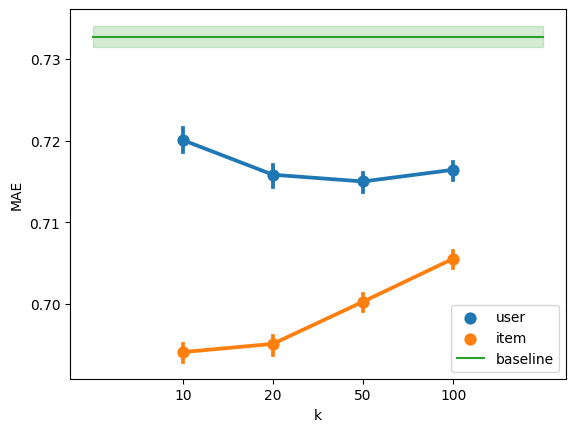

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

base_avg = baseline_df['MAE'].mean()
base_std = baseline_df['MAE'].std()
sns.pointplot(data=results_df, x='k', hue='mode', y='MAE')
nk = results_df['k'].nunique()
plt.plot([-1, nk], [base_avg, base_avg], label='baseline', color='C2')
plt.fill_between([-1, nk], [base_avg - base_std]*2, [base_avg+base_std]*2, color='C2', alpha=0.2)
plt.legend()
plt.show() #Item-item has lower MAE

In [16]:
#Matrix Factorization
def get_rating_matrix(X):
    """Function to generate a ratings matrx and mappings for
    the user and item ids to the row and column indices

    Parameters
    ----------
    X : pandas.DataFrame, shape=(n_ratings,>=3)
        First 3 columns must be in order of user, item, rating.

    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    """
    user_col, item_col, rating_col = X.columns[:3]
    rating = X[rating_col]
    user_map = pd.Series(
        index=np.unique(X[user_col]),
        data=np.arange(X[user_col].nunique()),
        name='user_map',
    )
    item_map = pd.Series(
        index=np.unique(X[item_col]),
        data=np.arange(X[item_col].nunique()),
        name='columns_map',
    )
    user_inds = X[user_col].map(user_map)
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table(
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map

In [17]:
class ALSRecommender():
    """Recommender based on Alternating Least Squares algorithm.
    
    Parameters
    ----------
    k : int, default=5
        Number of latent features
    lmbda : float, default=0.1
        Regularization parameter
    max_epochs : int, default=15
        Max number of iterations to run
    baseline_algo : object
        Object with fit(X) and 
    """
    def __init__(self, k=5, lmbda=0.1, max_epochs=15, baseline_algo=None, error_metric='mae',
                 verbose=True):
        # Force integer in case it comes in as float
        self.k = int(np.round(k))
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.baseline_algo = baseline_algo
        self.error_metric = error_metric
        self.verbose = verbose

        self.U = None
        self.I = None
        self.initialized = False

    def _calc_train_error(self, U, I, R, R_selector=None, error_metric='mae'):
        if R_selector is None:
            R_selector = (R > 0)
        R_hat = np.dot(U.T, I)
        if error_metric == 'mae':
            error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector)
        else:
            raise ValueError("{} is an unsupported error metric".format(metric))
        return error

    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
        else:
            self.baseline_algo.fit(X)
        self.R, self.user_map, self.item_map = get_rating_matrix(X)
        n_users, n_items = self.R.shape
        self.U = 3 * np.random.rand(self.k, n_users)
        self.I = 3 * np.random.rand(self.k, n_items)
        self.I[0, :] = self.R[self.R != 0].mean(axis=0) # Avg. rating for each movie
        self.E = np.eye(self.k) # (k x k)-dimensional idendity matrix
        self.epoch = 0
        self.train_errors = []
        self.initialized = True

    def fit(self, X, n_epochs=None):
        """Fit model to training data X. If at least one iteration has already been run,
        then the model will continue from its most recent state.

        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs

        Returns
        -------
        self
            This allows chaining like `ALSRecommender().fit(X_train).predict(X_test)`
        """
        # Allow continuation from previous state if n_epochs is given. Otherwise start from scratch.
        if n_epochs is None:
            self.initialized = False
        if not self.initialized:
            self._fit_init(X)

        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0

        n_users, n_items = self.R.shape

        # Run n_epochs iterations
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Fix I and estimate U
            for i, Ri in enumerate(self.R):
                nui = np.count_nonzero(Ri) # Number of items user i has rated
                if (nui == 0): nui = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ii
                Ri_nonzero_selector = np.nonzero(Ri)[0]
                # Select subset of I associated with movies reviewed by user i
                I_Ri = self.I[:, Ri_nonzero_selector]
                # Select subset of row R_i associated with movies reviewed by user i
                Ri_nonzero = self.R[i, Ri_nonzero_selector]
                Ai = np.dot(I_Ri, I_Ri.T) + self.lmbda * nui * self.E
                Vi = np.dot(I_Ri, Ri_nonzero.T)
                self.U[:, i] = np.linalg.solve(Ai, Vi)
            # Fix U and estimate I
            for j, Rj in enumerate(self.R.T):
                nmj = np.count_nonzero(Rj) # Number of users that rated item j
                if (nmj == 0): nmj = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ij
                Rj_nonzero_selector = np.nonzero(Rj)[0]
                # Select subset of P associated with users who reviewed movie j
                U_Rj = self.U[:, Rj_nonzero_selector]
                # Select subset of column R_j associated with users who reviewed movie j
                Rj_nonzero = self.R[Rj_nonzero_selector, j]
                Aj = np.dot(U_Rj, U_Rj.T) + self.lmbda * nmj * self.E
                Vj = np.dot(U_Rj, Rj_nonzero)
                self.I[:, j] = np.linalg.solve(Aj, Vj)
            error = self._calc_train_error(self.U, self.I, self.R)
            self.train_errors.append(error)
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    def predict(self, X):
        """Generate predictions for user/item pairs
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe
            
        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            Array of rating predictions for each user/item pair
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        rating_pred = np.array([
            np.sum(self.U[:, u_ind] * self.I[:, i_ind])
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        min_rating = np.min(self.R[np.nonzero(self.R)])
        max_rating = np.max(self.R)
        X.loc[X['rating'] < min_rating, 'rating'] = min_rating
        X.loc[X['rating'] > max_rating, 'rating'] = max_rating
        return X['rating'].values


In [18]:
%%time
n_splits = 5
max_epochs = 50
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_epochs))
test_errs = np.zeros((n_splits, max_epochs))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings)):
    print("i_fold={}".format(i_fold))
    train_df, test_df = ratings.iloc[train_inds], ratings.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    rec = ALSRecommender(k=20, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs)
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        preds = rec.predict(test_df[['user_id', 'movie_id']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        # print("[Epoch {}/{}] test MAE: {}".format(i_epoch, max_epochs, test_err))
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors)

print(f"There are {len(rec.user_map)} users and {len(rec.item_map)} items")

i_fold=0
i_fold=1
i_fold=2
i_fold=3
i_fold=4
There are 6040 users and 3680 items
CPU times: total: 8min 58s
Wall time: 14min 7s


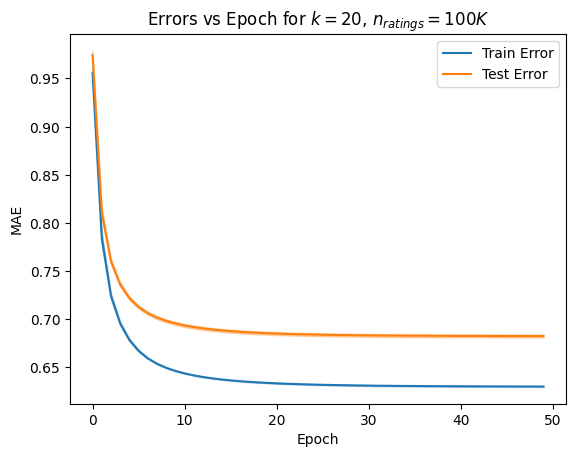

In [19]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.fill_between(np.arange(max_epochs), train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(r'Errors vs Epoch for $k=20$, $n_{ratings}=100K$')
plt.show()

In [22]:
n_splits = 5
max_epochs = 30
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [5, 10, 20, 50, 100]
small_df = ratings.iloc[:100000]
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = ALSRecommender(k=k, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs)
        rec.fit(train_df)
        preds = rec.predict(test_df[['user_id', 'movie_id']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=5, k=10, k=20, k=50, k=100, 
i_fold=1: k=5, k=10, k=20, k=50, k=100, 
i_fold=2: k=5, k=10, k=20, k=50, k=100, 
i_fold=3: k=5, k=10, k=20, k=50, k=100, 
i_fold=4: k=5, k=10, k=20, k=50, k=100, 


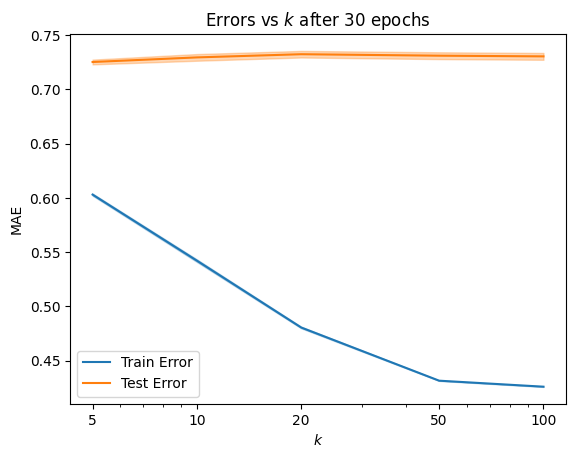

In [23]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, train_avg, label='Train Error')
plt.fill_between(k_list, train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel('MAE')
plt.title(r'Errors vs $k$ after {} epochs'.format(max_epochs))
plt.show() # optimal k=10